In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pyntcloud import PyntCloud
import plyfile as ply
import sys
import DracoPy
import shutil
import pandas as pd
import open3d as o3d
from tqdm import tqdm

Draco compression over the whole merged directory

In [3]:
import time
import plyfile

path_to_combined_data = 'dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset/dataset_final'
all_pc = glob.glob(os.path.join(path_to_combined_data, '*.ply'))


## Quality metric

It is possible to define different quality metrics to evaluate the quality of the compression in a pointcloud scenario.

In this case we decide to apply, mostly for computational reasons, the mean point distance error.


In [4]:
from scipy.spatial import KDTree
def mean_point_distance_error(points, decoded_points):

    # Create a KDTree of the decoded points
    decoded_points_tree = KDTree(decoded_points)
    # Find the closest point in the decoded point cloud for each point in the original point cloud
    distances, closest_indices = decoded_points_tree.query(points)
    # Get the closest points
    closest_points = decoded_points[closest_indices]
    # Calculate the mean point distance error
    mpde = np.mean(np.linalg.norm(points - closest_points, axis=1))
    return mpde

# Unlabelled pointcloud compression

Let us first compress the unlabelled pointclouds. We compress each of the 100 pointclouds obtained by merginf top, left and right LIDARS and compute the following metric:

- Compression ratio
- Mean point distance error
- Number of lost points
- Computation time

Note that compression ratio is computed as the ratio between the size of the compressed file and the size of the original file:

$$ \frac{size_{compressed}}{size_{original}} $$

Therefore, it represents how much the file has been compressed. The lower the better.

In [ ]:
draco_unlabeled = pd.DataFrame(columns=['filename', 'original_size', 'original_size_bytes', 
                                        'encoded_size', 
                                        'compression_ratio', 
                                        'encoding_decoding_time', 'lost_points', 'mpde'])

for pc in all_pc:

    # Start the timer
    start = time.time()

    # Read the ply file
    plydata = plyfile.PlyData.read(pc)
    # Extract the XYZ coordinates of the points
    points = np.vstack([plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']]).T

    # Measure the number of points in the original point cloud
    original_size = len(points)
    original_size_bytes = len(points.tobytes())


    # Encode the point cloud
    encoded_data = DracoPy.encode(points)
    encoded_size_bytes = len(encoded_data)

    # Measure the size of the encoded data
    encoded_size = len(encoded_data)
     # Calculate the compression ratio
    encoded_compression_ratio = (encoded_size_bytes / original_size_bytes)
    
    print (f"Original size: {original_size_bytes} points\tEncoded size: {encoded_size_bytes} bytes, \t Compression ratio: {encoded_compression_ratio}")

    # Decode the encoded data
    decoded_points = DracoPy.decode(encoded_data)
    # End the timer
    end = time.time()

    # save the decoded points
    decoded_points_filename = os.path.join('results', 'draco_unlabeled_decoded')

    # save the decoded points 
    if not os.path.exists(decoded_points_filename):
        os.makedirs(decoded_points_filename)
    
    decoded_points_filename = os.path.join(decoded_points_filename, os.path.basename(pc))
    ply_decoded = plyfile.PlyData(\
        [plyfile.PlyElement.describe(\
            np.array(list(zip(decoded_points.points[:,0], 
            decoded_points.points[:,1], 
            decoded_points.points[:,2])), 
            dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')]), 'vertex')])
            
    ply_decoded.write(decoded_points_filename + '.ply')

    #metric for quality of the decoded points
    mpde = mean_point_distance_error(points, decoded_points.points)

    # fiond nearest points to the decoded points in the original point cloud
    lost_points = len(points) - len(decoded_points.points)

    # Save the results
    draco_unlabeled = draco_unlabeled.append({'filename': pc, 
                                            'original_size': original_size, 
                                            'original_size_bytes': original_size_bytes, 
                                            'encoded_size': encoded_size, 
                                            'compression_ratio': encoded_compression_ratio, 
                                            'encoding_decoding_time': end - start, 
                                            'lost_points': lost_points,
                                            'mpde': mpde
                                            }, 
                                            ignore_index=True)

# save the results
draco_unlabeled.to_csv('results/draco_unlabeled.csv', index=False)


In [3]:
draco_unlabeled = pd.read_csv('results/draco_unlabeled.csv')

try:    
    draco_unlabeled = draco_unlabeled.drop(columns=['encoded_size_bytes', 'compression_ratio_bytes', 'original_size'])
except:
    pass

draco_unlabeled

,filename,original_size_bytes,encoded_size,compression_ratio,encoding_decoding_time,lost_points,mpde
0,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3416088,314512,0.092068,0.615055,0,0.005322
1,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3251676,299772,0.092190,0.452345,0,0.005561
2,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3462324,334056,0.096483,0.349651,1316,0.006069
3,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3274668,296048,0.090406,0.356713,3754,0.005172
4,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3278316,286544,0.087406,0.392556,565,0.005175
...,...,...,...,...,...,...,...
91,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3484380,337264,0.096793,0.458859,3561,0.005114
92,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3407268,319548,0.093784,0.544925,433,0.004996
93,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3227700,309704,0.095952,0.411857,603,0.005946
94,dataset-downloader-kit/CV/dataset/Town01_Opt_C...,3256320,298220,0.091582,0.419531,306,0.005488


In [9]:
# plot some results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', font_scale=1.5)


# aggregate the results
stats = pd.DataFrame(columns=draco_unlabeled.columns)
stats.loc['avg'] = draco_unlabeled.mean()
stats.loc['std'] = draco_unlabeled.std()

print (f" Average compression ratio: {stats.loc['avg', 'compression_ratio'] * 100:.1f} % pm {stats.loc['std', 'compression_ratio'] * 100:.1f} %")
print (f" Average encoding-decoding time: {stats.loc['avg', 'encoding_decoding_time']:.2f} seconds pm {stats.loc['std', 'encoding_decoding_time']:.2f} seconds")
print (f" Average lost points: {stats.loc['avg', 'lost_points']:.2f} points pm {stats.loc['std', 'lost_points']:.2f} points")
print (f" Average MPDE: {stats.loc['avg', 'mpde']:4f} meters pm {stats.loc['std', 'mpde']:.4f} meters")

 Average compression ratio: 8.9 % pm 0.5 %
 Average encoding-decoding time: 0.42 seconds pm 0.07 seconds
 Average lost points: 1861.33 points pm 1578.30 points
 Average MPDE: 0.005557 meters pm 0.0005 meters


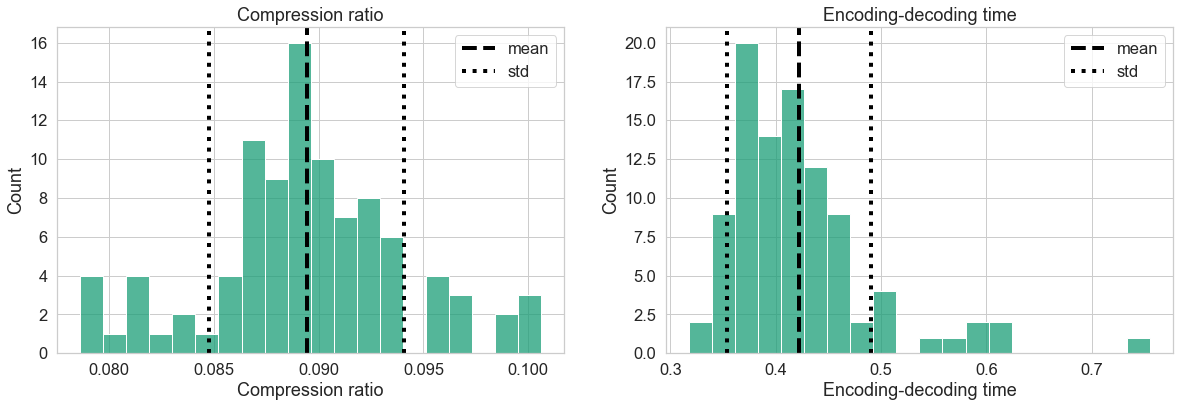

In [10]:
# plot 
sns.set_theme(style='whitegrid', font_scale=1.5, palette='Dark2')
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(data=draco_unlabeled, x='compression_ratio', ax=ax[0], bins=20)
sns.histplot(data=draco_unlabeled, x='encoding_decoding_time', ax=ax[1], bins=20) 

# add mean and std
lw = 4
ax[0].set_title('Compression ratio')
ax[1].set_title('Encoding-decoding time')

ax[0].set_xlabel('Compression ratio')
ax[1].set_xlabel('Encoding-decoding time')


ax[0].axvline(stats.loc['avg', 'compression_ratio'], color='black', linestyle='--', label='mean', linewidth=lw)
ax[0].axvline(stats.loc['avg', 'compression_ratio'] + stats.loc['std', 'compression_ratio'], color='black', linestyle=':', label='std', linewidth=lw)
ax[0].axvline(stats.loc['avg', 'compression_ratio'] - stats.loc['std', 'compression_ratio'], color='black', linestyle=':', linewidth=lw)
ax[0].legend()

ax[1].axvline(stats.loc['avg', 'encoding_decoding_time'], color='black', linestyle='--', label='mean', linewidth=lw)
ax[1].axvline(stats.loc['avg', 'encoding_decoding_time'] + stats.loc['std', 'encoding_decoding_time'], color='black', linestyle=':', label='std', linewidth=lw)
ax[1].axvline(stats.loc['avg', 'encoding_decoding_time'] - stats.loc['std', 'encoding_decoding_time'], color='black', linestyle=':', linewidth=lw)
ax[1].legend()



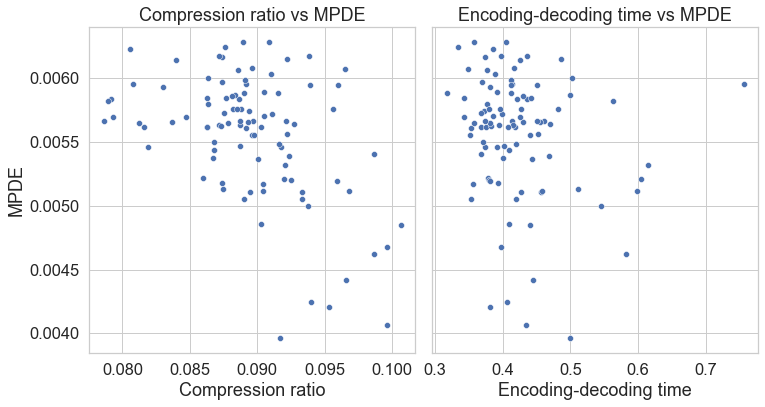

In [11]:
# quality vs compression 
sns.set_theme(style='whitegrid', font_scale=1.5, palette='deep')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=draco_unlabeled, x='compression_ratio', y='mpde', ax=ax[0])
sns.scatterplot(data=draco_unlabeled, x='encoding_decoding_time', y='mpde', ax=ax[1])
ax[0].set_title('Compression ratio vs MPDE')
ax[1].set_title('Encoding-decoding time vs MPDE')
ax[0].set_xlabel('Compression ratio')
ax[1].set_xlabel('Encoding-decoding time')
ax[0].set_ylabel('MPDE')
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
# ax[0].set_xticks(np.arange(0.
# share axis 
ax[0].set_ylim(ax[1].get_ylim())
fig.subplots_adjust(wspace=0.05)



## Labeled pointcloud

Let us now consider the dataset with the corresponding labels. In this case we compress the point cloud obtained by compressing each label individually and we compute all the considered metrics.

In [11]:
def draco_labeled (pc_file):
    # Read the ply file
    plydata = plyfile.PlyData.read(pc_file)

    # Extract the XYZ coordinates of the points
    points = np.column_stack((plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']))
    # Extract the labels of the points
    labels = plydata['vertex']['ObjTag']
    print (f"Number of labels: {len(np.unique(labels))}")

    # iterate over the labels and encode each label separately

    results_PC = pd.DataFrame(columns=['label',             
                                        'original_size',
                                        'encoded_size', 
                                        'compression_ratio',  
                                        'encoding_decoding_time', 
                                        'lost_points', 'mpde'])

    for label in np.unique(labels):
        start = time.time()
        mask = labels == label

        pc_label = points[mask]
        # print (f"Number of points in label {label}: {len(pc_label)}") 

        # Encode the point cloud
        encoded_data = DracoPy.encode(pc_label)

        # Measure the size of the encoded data
        encoded_size = len(encoded_data)
        encoded_size_bytes = len(encoded_data)
        original_size_bytes = sys.getsizeof(pc_label.tobytes())

        # Measure the number of points in the original point cloud
        original_size = len(points)
        print (f"Original size: {original_size_bytes} bytes \t Encoded size: {encoded_size_bytes} bytes")
        # Decode the encoded data
        decoded_points = DracoPy.decode(encoded_data)

        mpde = mean_point_distance_error(pc_label, decoded_points.points)

        # End the timer
        end = time.time()

        # Calculate the compression ratio
        compression_ratio_bytes =  (encoded_size_bytes / original_size_bytes)

        # Calculate the number of lost points
        lost_points = len(points) - len(decoded_points.points)
        results_PC = results_PC.append({'label': label,     
                                        'original_size': original_size,         
                                        'encoded_size': encoded_size,
                                        'compression_ratio': compression_ratio_bytes,
                                        'encoding_decoding_time': end - start,
                                        'lost_points': lost_points,
                                        'mpde': mpde
                                        },
                                        ignore_index=True)

    # save the results
    img_name = pc_file.split('/')[-1].split('.')[0]
    res_dir = 'results'
    
    results_PC.to_csv(os.path.join(res_dir, img_name+'draco_labeled.csv'), index=False)

    return results_PC
        

In [12]:
# go through all the files and save the results
draco_labeled_res = dict()
for file in all_pc:
    draco_labeled_res[file] = draco_labeled(file)

Number of labels: 18
Original size: 537 bytes 	 Encoded size: 256 bytes
Original size: 535365 bytes 	 Encoded size: 91892 bytes
Original size: 7221 bytes 	 Encoded size: 1780 bytes
Original size: 11049 bytes 	 Encoded size: 1988 bytes
Original size: 1082925 bytes 	 Encoded size: 102120 bytes
Original size: 699273 bytes 	 Encoded size: 95308 bytes
Original size: 4353 bytes 	 Encoded size: 1268 bytes
Original size: 562653 bytes 	 Encoded size: 70192 bytes
Original size: 138417 bytes 	 Encoded size: 25412 bytes
Original size: 81 bytes 	 Encoded size: 96 bytes
Original size: 1149 bytes 	 Encoded size: 356 bytes
Original size: 321 bytes 	 Encoded size: 152 bytes
Original size: 83997 bytes 	 Encoded size: 12940 bytes
Original size: 46125 bytes 	 Encoded size: 7016 bytes
Original size: 31857 bytes 	 Encoded size: 5144 bytes
Original size: 196389 bytes 	 Encoded size: 16640 bytes
Original size: 13821 bytes 	 Encoded size: 3768 bytes
Original size: 1149 bytes 	 Encoded size: 400 bytes
Number of

In [17]:
# read files 
draco_labeled_res = dict()
for file in all_pc:
    img_name = file.split('/')[-1].split('.')[0]
    res_dir = 'results'
    draco_labeled_res[file] = pd.read_csv(os.path.join(res_dir, img_name+'draco_labeled.csv'))


In [18]:
draco_labeled_res[file]

,label,original_size,encoded_size,encoding_decoding_time,lost_points,mpde,compression_ratio
0,0.0,274077.0,1144.0,0.003294,273738.0,0.003797,0.278956
1,1.0,274077.0,38856.0,0.049923,257984.0,0.003774,0.201159
2,2.0,274077.0,8352.0,0.010851,270365.0,0.005662,0.187361
3,5.0,274077.0,2440.0,0.004791,273013.0,0.005171,0.190610
4,7.0,274077.0,102624.0,0.312609,174783.0,0.003533,0.085746
5,8.0,274077.0,72440.0,0.162096,222403.0,0.004278,0.116757
6,9.0,274077.0,30364.0,0.051827,261476.0,0.005247,0.200760
7,10.0,274077.0,70184.0,0.131092,227192.0,0.000159,0.124738
8,11.0,274077.0,38644.0,0.058764,251756.0,0.002873,0.144256
9,12.0,274077.0,836.0,0.003122,273812.0,0.000685,0.260193


In [19]:
# stats for each label
stats_labels = pd.DataFrame(columns=['label', 
                                    'avg_compression_ratio', 
                                    'std_compression_ratio', 
                                    'avg_encoding_decoding_time', 
                                    'std_encoding_decoding_time', 
                                    'avg_lost_points/total_points', 
                                    'std_lost_points/total_points',
                                    'avg_mpde',
                                    ])
# for each label plot the avg compression ratio and the avg encoding-decoding time

all_labels = np.unique(np.concatenate([draco_labeled_res[file]['label'].values for file in all_pc]))
for label in all_labels:
    avg_compression_ratio = np.mean([draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['compression_ratio'].iloc[0] for file in all_pc if label in draco_labeled_res[file]['label'].values])
    std_compression_ratio = np.std([draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['compression_ratio'].iloc[0] for file in all_pc if label in draco_labeled_res[file]['label'].values])
    avg_encoding_decoding_time = np.mean([draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['encoding_decoding_time'].iloc[0] for file in all_pc if label in draco_labeled_res[file]['label'].values])
    std_encoding_decoding_time = np.std([draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['encoding_decoding_time'].iloc[0] for file in all_pc if label in draco_labeled_res[file]['label'].values])
    avg_lost_points = np.mean([draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['lost_points']/draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['original_size'].iloc[0]  for file in all_pc if label in draco_labeled_res[file]['label'].values])
    std_lost_points = np.std([draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['lost_points']/draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['original_size'].iloc[0]  for file in all_pc if label in draco_labeled_res[file]['label'].values])
    avg_mpde = np.mean([draco_labeled_res[file][draco_labeled_res[file]['label'] == label]['mpde'].iloc[0] for file in all_pc if label in draco_labeled_res[file]['label'].values])

    stats_labels = stats_labels.append({'label': label,
                                        'avg_compression_ratio': avg_compression_ratio, 
                                        'std_compression_ratio': std_compression_ratio,
                                        'avg_encoding_decoding_time': avg_encoding_decoding_time,
                                        'std_encoding_decoding_time': std_encoding_decoding_time,
                                        'avg_lost_points/total_points': avg_lost_points,
                                        'std_lost_points/total_points': std_lost_points,
                                        'avg_mpde': avg_mpde
                                        },
                                        ignore_index=True)

In [20]:
stats_labels

,label,avg_compression_ratio,std_compression_ratio,avg_encoding_decoding_time,std_encoding_decoding_time,avg_lost_points/total_points,std_lost_points/total_points,avg_mpde
0,0.0,0.213979,0.065690,0.046912,0.051920,0.949713,0.057275,0.004285
1,1.0,0.207564,0.045764,0.055434,0.041921,0.939731,0.043845,0.004182
2,2.0,0.215043,0.100345,0.013153,0.013533,0.985899,0.017724,0.004154
3,3.0,0.724464,0.390792,0.001846,0.000510,0.999755,0.000449,0.000327
4,5.0,0.178832,0.037474,0.005670,0.002732,0.994832,0.002975,0.004658
5,7.0,0.090361,0.006316,0.329025,0.057278,0.634253,0.044794,0.003427
6,8.0,0.124917,0.010122,0.155289,0.038902,0.823944,0.038224,0.003688
7,9.0,0.217767,0.117306,0.038156,0.019669,0.954100,0.024590,0.004989
8,10.0,0.124748,0.000021,0.141588,0.016786,0.828065,0.006561,0.000159
9,11.0,0.227799,0.082529,0.015390,0.015277,0.984710,0.018950,0.003460


Compression ratio is computed as 

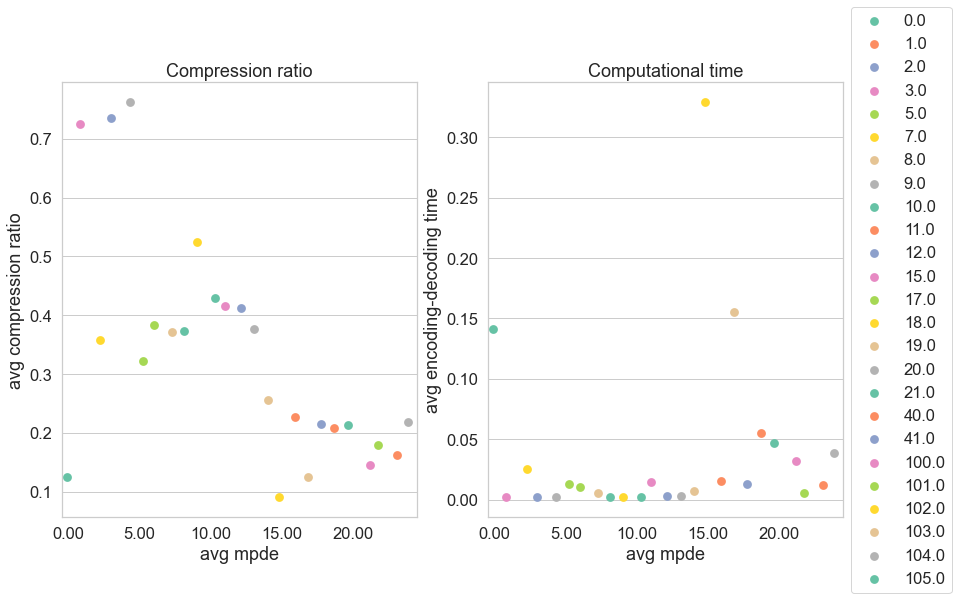

In [29]:
# plot the results
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

sns.set_theme(style="whitegrid", font_scale=1.5)
# add error bars
# ax[0].errorbar(stats_labels['avg_lost_points/total_points'], y=stats_labels['avg_compression_ratio'], yerr=stats_labels['std_compression_ratio'], fmt='o', color='black')
sns.pointplot(x='avg_mpde', y='avg_compression_ratio', data=stats_labels,  
                ax=ax[0], dodge=True, join=False, palette='Set2', hue='label')


ax[0].set_xlabel('avg mpde')
ax[0].set_ylabel('avg compression ratio')
ax[0].set_title('Compression ratio')
# set xticks with double precision
from matplotlib.ticker import FormatStrFormatter 
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# print xticks every 5 ticks
for i, label in enumerate(ax[0].get_xticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
    

#remove the legend
ax[0].legend_.remove()

sns.pointplot(x='avg_mpde', y='avg_encoding_decoding_time', data=stats_labels,  ax=ax[1], dodge=True, join=False, palette='Set2', hue='label')
ax[1].set_xlabel('avg mpde')
ax[1].set_ylabel('avg encoding-decoding time')
ax[1].set_title('Computational time')
# put legend outside the plot
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

# set xticks with double precision
from matplotlib.ticker import FormatStrFormatter
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# print xticks every 5 ticks
for i, label in enumerate(ax[1].get_xticklabels()):
    if i % 5 != 0:
        label.set_visible(False)

plt.show()